# Measuring MTF from Blocks in TO4

In [1]:
%matplotlib inline
from __future__ import division, print_function

import numpy as np
from mriqa.phantoms import phantom_mask_2d, find_phantom, TO4
from mriqa.tools import show_mosaic
from mriqa.dcmio import fetch_series
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom as ndizoom
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, fixed

Fetch a series with TO4 images. We'll pick the highest resolution (1024 matrix)

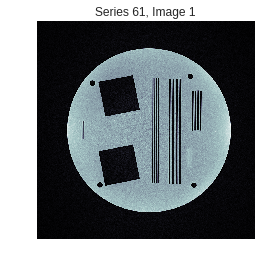

In [2]:
# TO4
dobjs = fetch_series(patid='PQA20140603RHD', sernos=[61])
images = [d.pixel_array & 0xfff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
image = images[0]

show_mosaic(dobjs, cmap='bone')

Pick A ROI round one of the MTF blocks.

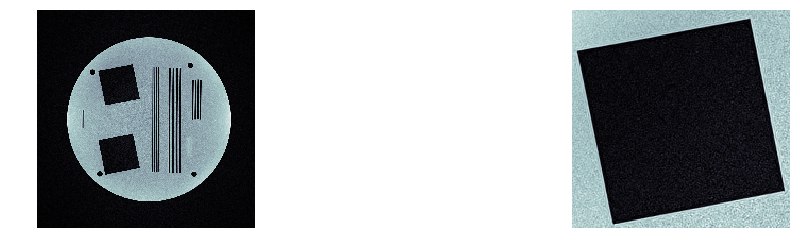

Matrix: 1024 x 1024
Pixel Sizes: 0.24 x 0.24 mm


In [3]:
phantom = TO4

# Centre phantom
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

blocks = phantom['Features']['Blocks']

(x, y), (dx, dy) = np.array(blocks[0]) / pix_dims
# are we missing an off by one adjustment here?
x += centre_x
y += centre_y

x = int(round(x))
y = int(round(y))
dx = int(round(dx))
dy = int(round(dy))

roi = image[y:y+dy, x:x+dx]

# Plotting area
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig.subplots_adjust(wspace=0.5)

# Phantom image
axes[0].imshow(image, cmap='bone')
axes[0].axis('off')
axes[0].axis('image')

axes[1].imshow(roi, cmap='bone')
axes[1].axis('off')
axes[1].axis('image')
plt.show()
print('Matrix: %d x %d' % image.shape)
print('Pixel Sizes: %0.2f x %0.2f mm' % tuple(pix_dims))


Ideally, we'd like to fit a whole strip with a error function edge. This would have two parameters for the fitted straight line but also a (potentially variable?) edge width and if there is non-uniformity some sort of low order multiplier (another 3 or 4 parameters). We'll take a sub ROI around just one edge to work with.

(50, 150)


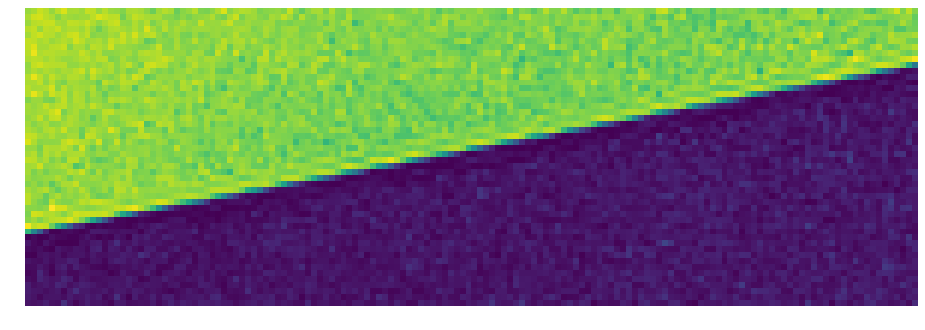

In [4]:
subroi = roi[:50, 10:160]
plt.figure(figsize=(16, 8))
plt.imshow(subroi, cmap='viridis')
plt.axis('off')
plt.grid(False)
print(subroi.shape)

We could try a simple edge detection first to get the rough slope and offset. We'll try a few different methods.

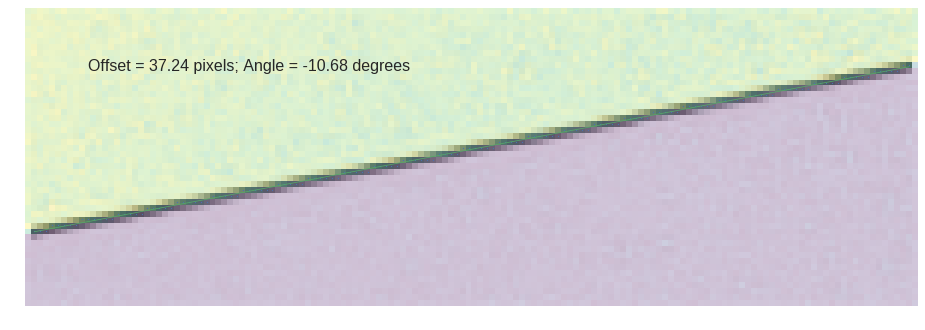

In [5]:
from skimage.filters import roberts, sobel, scharr, prewitt
method_dict = {
    'roberts': roberts,
    'sobel':   sobel,
    'scharr':  scharr,
    'prewitt': prewitt 
}

@interact(method=method_dict)
def show_edges(method):
    plt.figure(figsize=(16, 8))
    edges = method(subroi)
    plt.imshow(subroi, cmap='viridis', alpha=0.5)
    plt.imshow(edges, alpha=0.5)
    plt.grid(None)
    plt.axis('off')
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    plt.plot(X, Y, '.', markersize=2.5)
    a, b = np.polyfit(X, Y, deg=1)
    plt.plot(X, a*X + b, linewidth=0.75)
    angle = np.degrees(np.arctan(a))
    offset = b
    plt.text(10, 10, 'Offset = %0.2f pixels; Angle = %0.2f degrees' % (offset, angle), fontsize=16)

They all actually work pretty well. We could use this as a starting point for a more general fit and see if it makes any difference. The general function will model the edge thickness and a quadratic gain field as well as the edge position and slope.

In [6]:
from scipy.special import erfc
from scipy.optimize import curve_fit

def model(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # linear model of edge position
    loc = intercept + x * slope
    # complementary error function model of edge transition
    result =  gain * (i0 + (i1 - i0) * erfc((y-loc) / sigma))
    # curve_fit() needs the image flattened to 1D
    return result.ravel()

# Coordinates
X, Y = np.meshgrid(np.arange(subroi.shape[1]), np.arange(subroi.shape[0]))

# Starting Point
i0_0 = subroi[-10:, -10:].mean()
i1_0 = subroi[:10, :10].mean()

a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
sigma_0 = 1.0

intercept_0 = 36.67
slope_0 = -0.1895
p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

# Data to fit
ydata = subroi.copy()

The 'model' image using these initial parameters.

Starting parameters: [122.44, 1525.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 36.67, -0.1895]


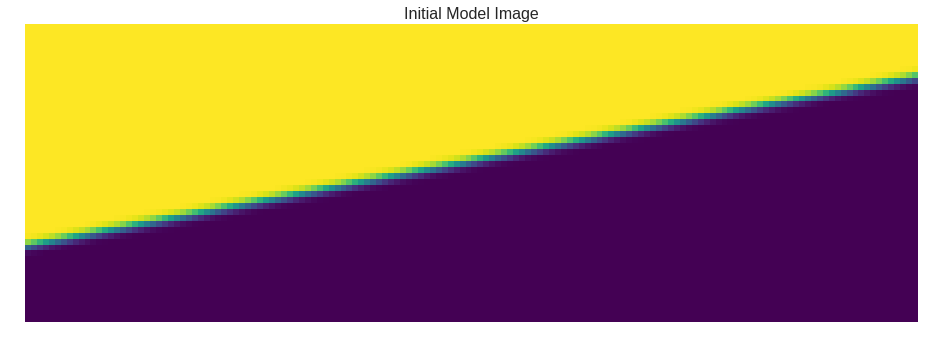

In [7]:
print('Starting parameters:', p0)

assert X.shape == Y.shape == subroi.shape
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *p0).reshape(ydata.shape), cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image', fontsize=16);

And this is the residual between that and the actual image.

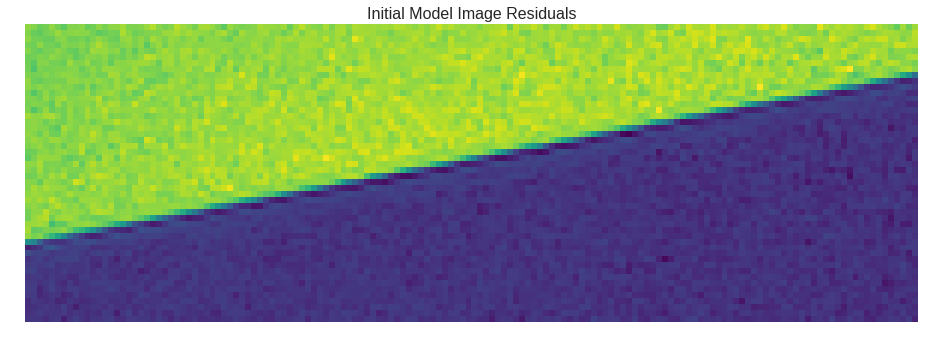

In [8]:
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *p0).reshape(ydata.shape)-ydata, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image Residuals', fontsize=16);

Now we'll fit the model using scipy `curve_fit`.

In [9]:
popt, pcov = curve_fit(model, xdata=(X, Y), ydata=ydata.ravel(), p0=p0)

This is the new model image.

Fitted parameters:
125.42313, 1090.16810, 0.77892, -0.00218, -0.00528, 0.00001, 0.00011, 0.00004, 0.44511, 37.24987, -0.18903


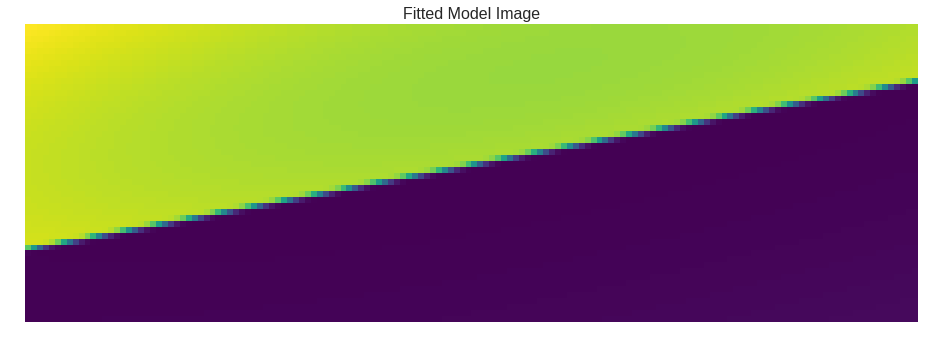

In [10]:
print('Fitted parameters:')
print(', '.join(['%0.5f' % p for p in popt]))
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *popt).reshape(ydata.shape), cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fitted Model Image', fontsize=16);

And the residuals now are much smaller - the fit seems pretty good.

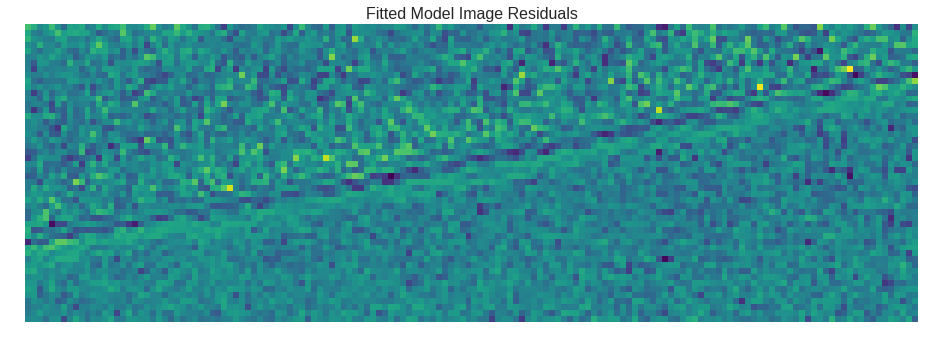

In [11]:
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *popt).reshape(ydata.shape)-ydata, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fitted Model Image Residuals', fontsize=16);

Now we have an accurate angle and intercept we need to do some sort of interpolation with offset. We'll try taking the whole part of the shifts for each column and apply those to the orginal image. We can do the subpixel parts in an interpolated version of the image afterwards.

In [12]:
i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt

In [13]:
nrows, ncols = ydata.shape
column_shifts = slope * np.arange(ncols)
whole_shifts = np.floor(column_shifts).astype(int)
aligned = np.zeros_like(ydata)
for col, shift in enumerate(whole_shifts):
    aligned[:, col] = np.roll(ydata[:, col], -shift)
    # all shifts will be negative - patch up leading edge
    if shift < 0:
        aligned[:-shift, col] = ydata[0, col]

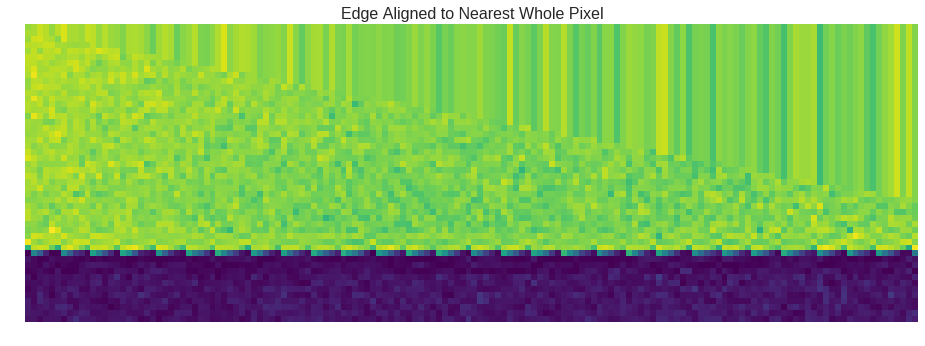

In [14]:
plt.figure(figsize=(16, 8))
plt.imshow(aligned, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge Aligned to Nearest Whole Pixel', fontsize=16);

Select a small window around the (now) horizontal edge so the interpolation isn't too expensive. 

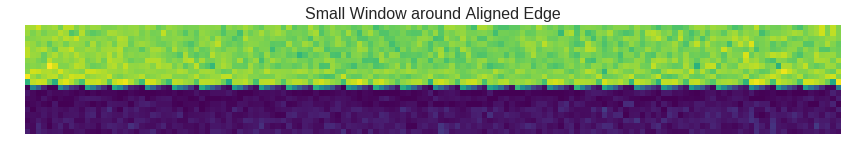

In [15]:
centre = int(round(intercept))
window = 10
al_windowed = aligned[centre-window:centre+window, :]
plt.figure(figsize=(16, 2))
plt.imshow(al_windowed, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Small Window around Aligned Edge', fontsize=16);

We'll now interpolate up (in the column direction only) so we can do finer grain pixel shifting. I think, in principle, we'd like to do sinc interpolation. Can we do that accurately when we have only a small window? Normally, we'd do this with zero filling in the frequency domain but we may be safer here with a direct matrix operation with the sinc kernel.

Wait, does this sinc interpolation already do the subsampling we want?

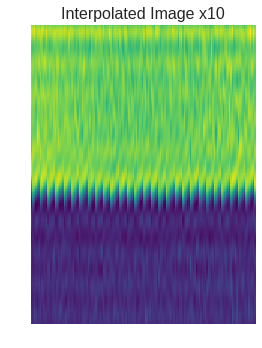

In [16]:
# Interpolation factor
k = 10
nrows, ncols = al_windowed.shape
n = nrows
nn = n * k

# Sinc kernel
[T, Ts]  = np.mgrid[1:n:nn*1j, 1:n:n*1j]
kernel = np.sinc(Ts - T)

hires = np.zeros((nrows*k, ncols))
for col in range(ncols):
    hires[:, col] = kernel.dot(al_windowed[:, col])
    
plt.figure()
plt.imshow(hires, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Interpolated Image x%d' % k, fontsize=16);

We'll now apply the fractional parts of the original shifts as integer shifts in this interpolated array. 

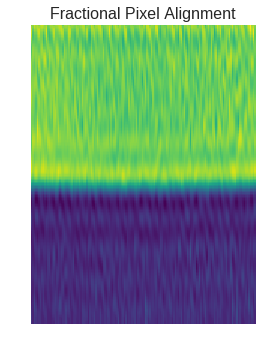

In [17]:
hires_shifted = np.zeros_like(hires)
fractional_shifts = (k * (column_shifts - np.floor(column_shifts))).astype(int)
for col, shift in enumerate(fractional_shifts):
    hires_shifted[:, col] = np.roll(hires[:, col], -shift)
    # all shifts will be positive - patch up trailing edge
    if shift > 0:
        hires_shifted[-shift:, col] = hires[-1, col]
plt.figure()
plt.imshow(hires_shifted, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fractional Pixel Alignment', fontsize=16);

We'll window it in a bit to avoid some of the rippling towards the edges. We still have a very noticable sinc ringing though. It's even more noticable if we take the derivative as we'll want to do for the LSF.

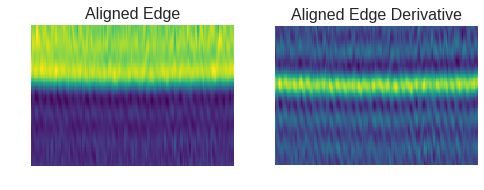

In [18]:
hires_windowed = hires_shifted[64:-32]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(hires_windowed, cmap='viridis')
axs[0].axis('off')
axs[0].grid(False)
axs[0].set_title('Aligned Edge', fontsize=16);
axs[1].imshow(-np.diff(hires_windowed, axis=0), cmap='viridis')
axs[1].axis('off')
axs[1].grid(False)
axs[1].set_title('Aligned Edge Derivative', fontsize=16);

These should now be aligned samples of the edge spread function, so we just need to project along the rows. The resultant edge response can be differentiated to give the corresponding line response.

We could further fit a low order polynomial to the edge here to further refine the aligment before projecting ...

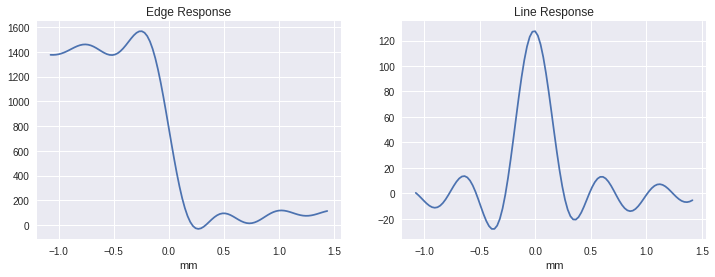

In [19]:
edge_response = hires_windowed.mean(axis=1)
line_response = -np.diff(edge_response)
pk_ind = np.argmax(line_response)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x_axis_edge = (np.arange(len(edge_response)) - pk_ind) * pix_dims[0] / k
axs[0].plot(x_axis_edge, edge_response)
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')

x_axis_line = (np.arange(len(line_response)) - pk_ind) * pix_dims[0] / k
axs[1].plot(x_axis_line, line_response)
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm');

The MTF should be the Fourier transform of the line reponse. We should try and centre the response really, but the offset should (by the fourier shift theorem) just generate a phase modulation and we are only interested in the magnitude so it doesn't really matter. 

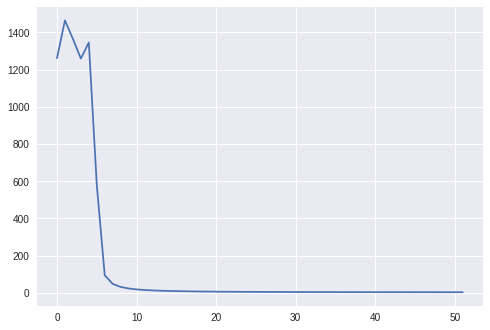

In [20]:
from numpy.fft import rfft, fftshift, fft
mtf = np.abs(rfft(line_response))
plt.plot(mtf);

This is in lines per pixel in interpolated image. We need to divide? by k to get lines per pixel in the original image. Then we need to scale by the projection angle of the edge (multiply by $\sin \alpha$ or $\tan \alpha$ ?) and finally divide by the pixel size to lines per mm.

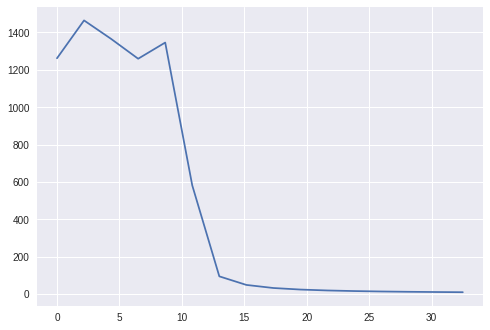

In [21]:
x_axis = np.arange(len(mtf)) / k / abs(slope) / pix_dims[0]
plt.plot(x_axis[:16], mtf[:16]);

There does seem to be a bit of a mess at the lower spatial frequencies. That may be from the rather obvious ripple in the ESF/LSF. Maybe this would average out if we combined the estimates from mulitiple edges. Have a look at log transformed data and see if it is any better. How is it normally presented? We may want to change the interpolation scheme - maybe we need to window the sinc interpolation to fix the ringing. If we don't have a clean low frequency part it's a bit difficult to estimate the frequency at one half maximum. We could throw away the outer edges of the LSF as they are not very meaningful past 2 or 3 mm. We also didn't apply the non uniformity correction from the model fit - that might help a bit.

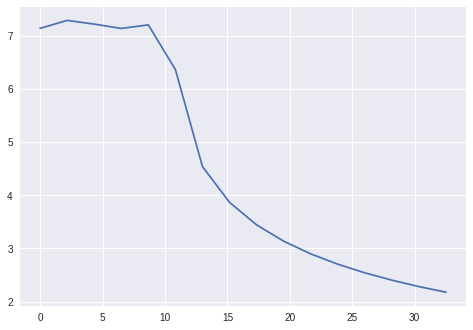

In [22]:
plt.plot(x_axis[:16], np.log(mtf)[:16]);

Something doesn't seem right here. We don't seem to have gained any subpixel resolution in the edge function. Is there something wrong with the method? Should we be using binning instead? Or, better, a KDE.

For each actual pixel we should know its extrapolated position on the edge. If we generate a KDE for this unevenly spaced data we should have the edge spread function. How do we get the position on the edge for each pixel? It's just the distance from the pixel centre to the edge regression line.

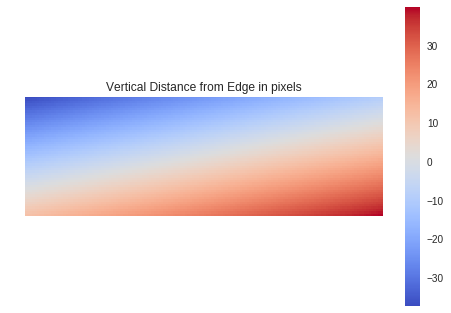

In [23]:
nrows, ncols = subroi.shape
distances = np.arange(nrows)[:, None] * np.ones(ncols)[None, :] - (intercept + slope * np.arange(ncols))
plt.imshow(distances, cmap='coolwarm')
plt.axis('off')
plt.grid(False)
plt.title('Vertical Distance from Edge in pixels')
plt.colorbar();

OK, this looks right - we have a smoothly varying distance from edge. What we actually need now is a *weighted* KDE. That is each point adds in with a multiplicity proportional to the image intensity. Otherwise, we'd need to convert the pixel values into some sort of multiplicity manually, which sounds slow and messy and would greatly increase the size of the problem. The sklearn and scipy kernel density estimators don't seem to support this, but it looks like the statsmodels one might.

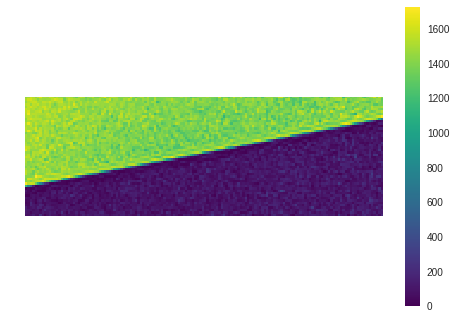

In [24]:
nrows, ncols = subroi.shape
plt.imshow(subroi, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.colorbar();

(0, 6)

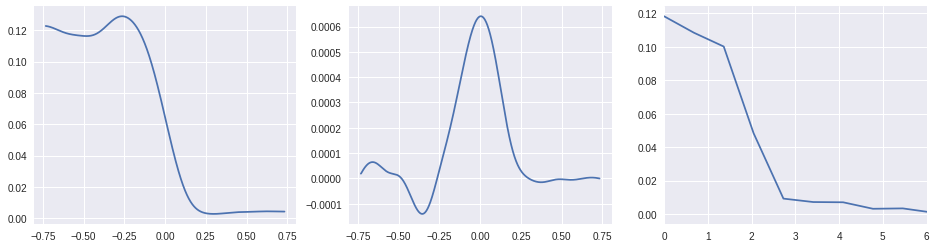

In [25]:
import statsmodels.api as sm
d = distances[np.abs(distances) < 8]
w = subroi[np.abs(distances) < 8].astype('float')

kde = sm.nonparametric.KDEUnivariate(d)
kde.fit(fft=False, weights=w, bw=0.25)
# in pixels
x = np.linspace(-3, 3, 1024)
esf = kde.evaluate(x)
lsf = -np.gradient(esf)
mtf = abs(np.fft.fft(lsf))
freqs = np.fft.fftfreq(len(lsf), x[1]-x[0])
mtf = np.fft.fftshift(mtf)
freqs = np.fft.fftshift(freqs)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].plot(x * pix_dims[0], esf)
axs[1].plot(x * pix_dims[0], lsf)
axs[2].plot(freqs / pix_dims[0], mtf, '-')
axs[2].set_xlim([0, 6])

This still doesn't seem to be giving us any subpixel resolution ... OK, the inner portion of this looks reasonable (it goes pretty crazy outside of +/- 6 pixels). There is also a problem with the bandwidth. A larger (including the default) bandwidth seems to wash out the esf, and a lower one makes a very noise lsf with lots of spikes in the msf. We've also got hardly any points across the mtf.

----

----

----

Oops, maybe we've got this the wrong way round and want to go across the edge the other way ...

In [26]:
nrows, ncols = ydata.shape

row_shifts = np.arange(nrows) / slope
whole_shifts = np.floor(row_shifts).astype(int)
aligned = np.zeros_like(ydata)
for row, shift in enumerate(whole_shifts):
    aligned[row, :] = np.roll(ydata[row, :], -shift)
    # all shifts will be negative - patch up leading edge
    #if shift < 0:
        #aligned[row, :-shift] = ydata[row, 0]

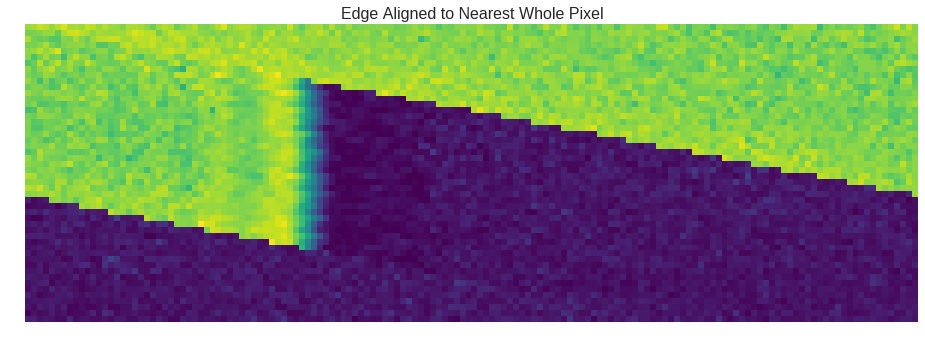

In [27]:
plt.figure(figsize=(16, 8))
plt.imshow(aligned, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge Aligned to Nearest Whole Pixel', fontsize=16);

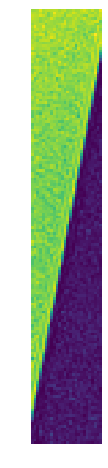

In [28]:
subroi = roi[10:36, 5:165].T
plt.figure(figsize=(16, 8))
plt.imshow(subroi, cmap='viridis')
plt.axis('off')
plt.grid(False)

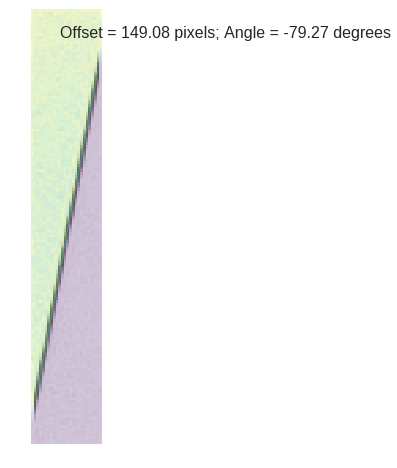

In [29]:
from skimage.filters import roberts, sobel, scharr, prewitt
method_dict = {
    'roberts': roberts,
    'sobel':   sobel,
    'scharr':  scharr,
    'prewitt': prewitt 
}

@interact(method=method_dict)
def show_edges(method):
    plt.figure(figsize=(4, 8))
    edges = method(subroi)
    plt.imshow(subroi, cmap='viridis', alpha=0.5)
    plt.imshow(edges, alpha=0.5)
    plt.grid(None)
    plt.axis('off')
    points = []
    for i, col in enumerate(edges.T):
        x, y = i, np.argmax(col)
        points.append((x, y))
    X, Y = np.asarray(points).T
    X, Y = X[1:-1], Y[1:-1]
    plt.plot(X, Y, '.', markersize=2.5)
    a, b = np.polyfit(X, Y, deg=1)
    plt.plot(X, a*X + b, linewidth=0.75)
    angle = np.degrees(np.arctan(a))
    offset = b
    plt.text(10, 10, 'Offset = %0.2f pixels; Angle = %0.2f degrees' % (offset, angle), fontsize=16)

In [30]:
from scipy.special import erfc
from scipy.optimize import curve_fit

def model(XY, i0, i1, a, b, c, d, e, f, sigma, intercept, slope):
    x, y = XY
    # quadratic model of bias field
    gain = a + b*x + c*y + d * x**2 + e * y**2 + f * x*y
    # linear model of edge position
    loc = intercept + x * slope
    # complementary error function model of edge transition
    result =  gain * (i0 + (i1 - i0) * erfc((y-loc) / sigma))
    # curve_fit() needs the image flattened to 1D
    return result.ravel()

# Coordinates
X, Y = np.meshgrid(np.arange(subroi.shape[1]), np.arange(subroi.shape[0]))

# Starting Point
i0_0 = subroi[-10:, -10:].mean()
i1_0 = subroi[:10, :10].mean()

a_0 = 1.0; b_0 = c_0 = d_0 = e_0 = f_0 = 0.0
sigma_0 = 1.0

intercept_0 = 146
slope_0 = -5.3
p0 = [i0_0, i1_0, a_0, b_0, c_0, d_0, e_0, f_0, sigma_0, intercept_0, slope_0]

# Data to fit
ydata = subroi

Starting parameters: [116.23999999999999, 1508.6900000000001, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 146, -5.3]


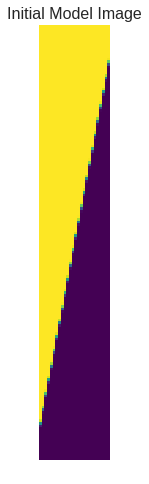

In [31]:
print('Starting parameters:', p0)

assert X.shape == Y.shape == subroi.shape
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *p0).reshape(ydata.shape), cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image', fontsize=16);

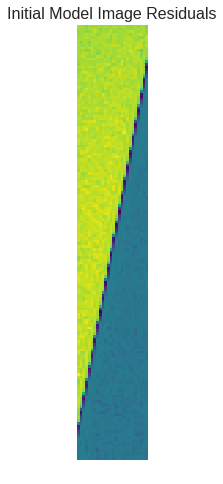

In [32]:
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *p0).reshape(ydata.shape)-ydata, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Initial Model Image Residuals', fontsize=16);

In [33]:
popt, pcov = curve_fit(model, xdata=(X, Y), ydata=ydata.ravel(), p0=p0)

Fitted parameters:
155.78153, 1414.48346, 0.59738, -0.00525, -0.00217, 0.00017, 0.00001, 0.00007, 2.40562, 149.07739, -5.28283


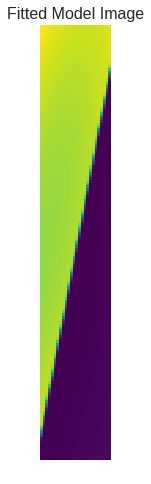

In [34]:
print('Fitted parameters:')
print(', '.join(['%0.5f' % p for p in popt]))
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *popt).reshape(ydata.shape), cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fitted Model Image', fontsize=16);

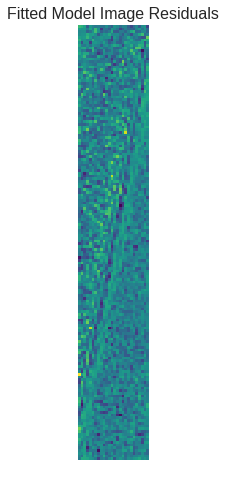

In [35]:
plt.figure(figsize=(16, 8))
plt.imshow(model((X, Y), *popt).reshape(ydata.shape)-ydata, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fitted Model Image Residuals', fontsize=16);

In [36]:
i0, i1, a, b, c, d, e, f, sigma, intercept, slope = popt

Fitted parameters:
155.78153, 1414.48346, 0.59738, -0.00525, -0.00217, 0.00017, 0.00001, 0.00007, 2.40562, 149.07739, -5.28283


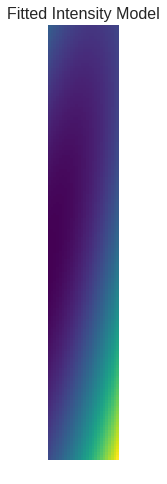

In [37]:
print('Fitted parameters:')
print(', '.join(['%0.5f' % p for p in popt]))
plt.figure(figsize=(16, 8))
gain = model((X, Y), 1, 1, a, b, c, d, e, f, 1, 0, 0).reshape(ydata.shape)
plt.imshow(gain, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fitted Intensity Model', fontsize=16);

In [38]:
nrows, ncols = ydata.shape
column_shifts = slope * np.arange(ncols)
whole_shifts = np.floor(column_shifts).astype(int)
aligned = np.zeros_like(ydata)
for col, shift in enumerate(whole_shifts):
    aligned[:, col] = np.roll((ydata/gain)[:, col], -shift)
    # all shifts will be negative - patch up leading edge
    #if shift < 0:
        #aligned[:-shift, col] = ydata[0, col]

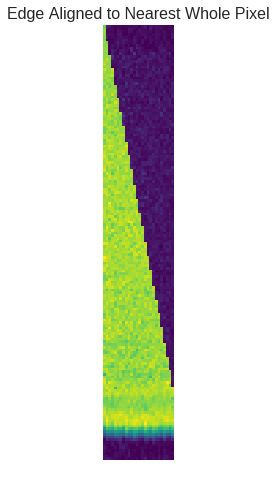

In [39]:
plt.figure(figsize=(16, 8))
plt.imshow(aligned, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Edge Aligned to Nearest Whole Pixel', fontsize=16);

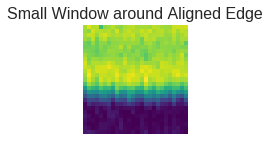

In [40]:
centre = int(round(intercept))
window = 16
al_windowed = aligned[centre-window:centre+window, :]
plt.figure(figsize=(16, 2))
plt.imshow(al_windowed, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Small Window around Aligned Edge', fontsize=16);

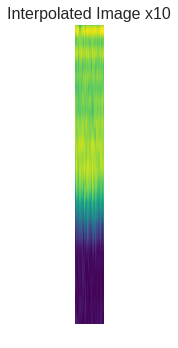

In [41]:
# Interpolation factor
k = 10
nrows, ncols = al_windowed.shape
n = nrows
nn = n * k

# Sinc kernel
[T, Ts]  = np.mgrid[1:n:nn*1j, 1:n:n*1j]
kernel = np.sinc(Ts - T)

hires = np.zeros((nrows*k, ncols))
for col in range(ncols):
    hires[:, col] = kernel.dot(al_windowed[:, col])
    
plt.figure()
plt.imshow(hires, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Interpolated Image x%d' % k, fontsize=16);

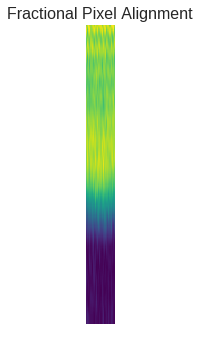

In [42]:
hires_shifted = np.zeros_like(hires)
fractional_shifts = (k * (column_shifts - np.floor(column_shifts))).astype(int)
for col, shift in enumerate(fractional_shifts):
    hires_shifted[:, col] = np.roll(hires[:, col], -shift)
    # all shifts will be positive - patch up trailing edge
    if shift > 0:
        hires_shifted[-shift:, col] = hires[-1, col]
plt.figure()
plt.imshow(hires_shifted, cmap='viridis')
plt.axis('off')
plt.grid(False)
plt.title('Fractional Pixel Alignment', fontsize=16);

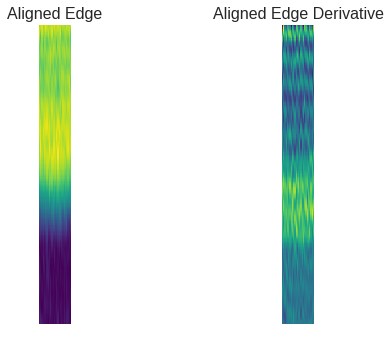

In [43]:
hires_windowed = hires_shifted[20:-5]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(hires_windowed, cmap='viridis')
axs[0].axis('off')
axs[0].grid(False)
axs[0].set_title('Aligned Edge', fontsize=16);
axs[1].imshow(-np.diff(hires_windowed, axis=0), cmap='viridis')
axs[1].axis('off')
axs[1].grid(False)
axs[1].set_title('Aligned Edge Derivative', fontsize=16);

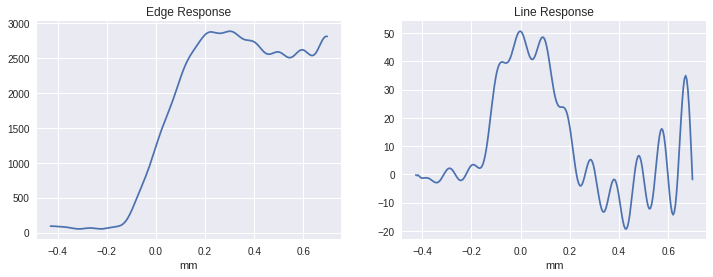

In [44]:
edge_response = hires_windowed.mean(axis=1)
line_response = -np.diff(edge_response)
pk_ind = np.argmax(line_response)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x_axis_edge = (np.arange(len(edge_response)) - pk_ind) * pix_dims[1] / k / slope
axs[0].plot(x_axis_edge, edge_response)
axs[0].set_title('Edge Response')
axs[0].set_xlabel('mm')

x_axis_line = (np.arange(len(line_response)) - pk_ind) * pix_dims[1] / k / slope
axs[1].plot(x_axis_line, line_response)
axs[1].set_title('Line Response')
axs[1].set_xlabel('mm');

In [45]:
np.degrees(np.arctan(-slope))

79.281172303082272

Need to sort out:
 - scaling: sin, cos or tan ?
 - ringing appears in interpolated image - why?
 - 

How does the geometrical factor get included? There should be a tan factor somewhere as we are not going straight across edge. An edge spread out over several mm corresponds to something quite narrow. A step edge will get stretched out to a ramp. 

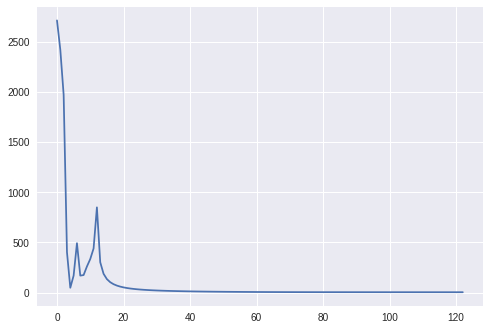

In [46]:
from numpy.fft import rfft, fftshift, fft
mtf = np.abs(rfft(line_response))
plt.plot(mtf);